In [1]:
from functools import reduce
from operator import mul
from pathlib import Path

import colorcet as cc
import h5py
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
import scipy
import skimage
from einops import rearrange


pv.set_jupyter_backend("static")

datadir = Path("../data/SIM")


In [2]:
def read_SIM_data(filepath: Path | str):
    f = h5py.File(filepath)
    data = f["Data"][:]
    pixel_sizes = f["Data"].attrs["pixel_sizes"]
    dtype = data.dtype
    if dtype.kind == "u":
        data = data / np.iinfo(dtype).max
    return data, pixel_sizes


data, pixel_sizes = read_SIM_data(datadir / "myosin/Image20_myosin_SIM2.h5")

data.dtype

dtype('float64')

In [3]:
pixel_sizes

array([0.14412245, 0.03130297, 0.03130297], dtype=float32)

In [4]:
np.array(data[0].shape[::-1]) + 1

array([513, 513,  40])

In [5]:
grid = pv.ImageData(
    dimensions=np.array(data[0].shape[::-1]) + 1, spacing=pixel_sizes[::-1]
)
grid.cell_data["desmin"] = np.permute_dims(data[0], (2, 1, 0)).flatten(order="F")

grid2 = pv.ImageData(
    dimensions=np.array(data[0].shape[::-1]) + 1, spacing=pixel_sizes[::-1]
)
grid2.cell_data["myosin"] = np.permute_dims(data[1], (2, 1, 0)).flatten(order="F")


2025-10-18 15:17:50.306 (   3.343s) [    1525BA2B1740]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=


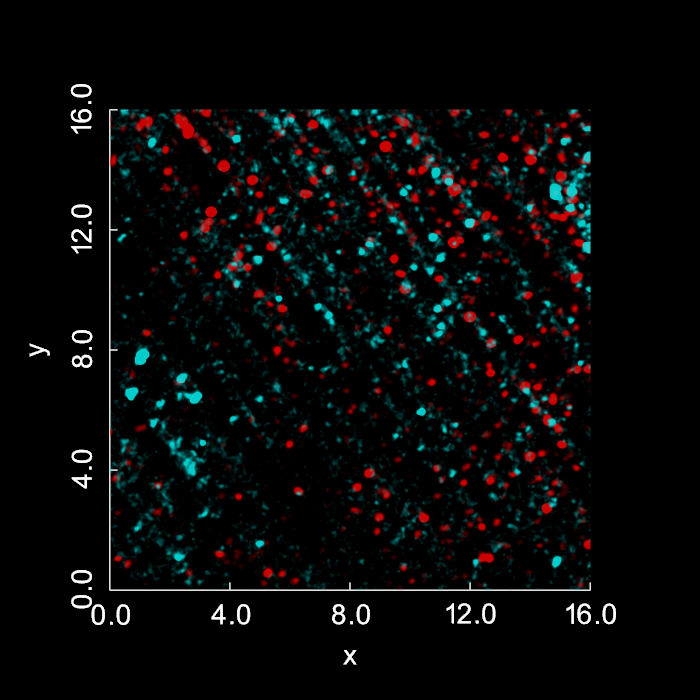

In [6]:
pl = pv.Plotter(notebook=True, window_size=(700, 700))
actor = pl.add_volume(
    grid,
    cmap=["#FF0000"],
    opacity=[0.0, 0.1, 0.8],
    clim=(0, 0.2),
    blending="maximum",
    show_scalar_bar=False,
)
actor.prop.interpolation_type = "linear"
actor = pl.add_volume(
    grid2,
    cmap=["#00FFFF"],
    opacity=[0.0, 0.1, 0.8],
    clim=(0, 0.2),
    # opacity_unit_distance=1.5,
    blending="maximum",
    show_scalar_bar=False,
)
actor.prop.interpolation_type = "linear"
pl.set_background(color="black")
pl.enable_parallel_projection()

pl.view_xy()
axis = pl.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="x",
    ytitle="y",
)
pl.show()

In [5]:
def deming_regression(x, y) -> tuple[float, float]:
    x_mean, y_mean = np.mean(x), np.mean(y)
    x_, y_ = x - x_mean, y - y_mean
    s_xx, s_yy = np.mean(x_ * x_), np.mean(y_ * y_)
    s_xy = np.mean(x_ * y_)
    p = (s_xx - s_yy) / (2 * s_xy)
    slope = -p + np.sqrt(1 + p * p)
    intercept = y_mean - slope * x_mean
    return slope, intercept


def pearson_r(x, y) -> float:
    x_, y_ = x - np.mean(x), y - np.mean(y)
    s_xx, s_yy = np.mean(x_ * x_), np.mean(y_ * y_)
    s_xy = np.mean(x_ * y_)
    return s_xy / np.sqrt(s_xx * s_yy)

In [8]:
a, b

NameError: name 'a' is not defined

(0.0, 0.5)

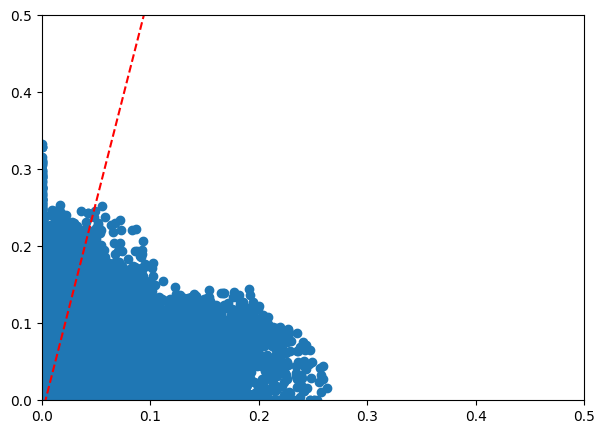

In [46]:
X, Y = data[0, :, 0:128, :128].flatten(), data[1, :, 0:128, :128].flatten()
a, b = deming_regression(X, Y)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter(X, Y)
x = np.linspace(0, 0.25, 100)
ax.plot(x, a * x + b, "--", color="red")
ax.set_xlim((0, 0.5))
ax.set_ylim((0, 0.5))

In [6]:
def colocalization_costes(
    channel1: np.ndarray, channel2: np.ndarray, *, n_threshold_bins: int = 100
):
    x, y = channel1.flatten(), channel2.flatten()
    a, b = deming_regression(X, Y)

    threshold_max = np.minimum(np.max(x), (np.max(y) - b) / a)
    thresholds = np.linspace(0, threshold_max, n_threshold_bins)

    for t in thresholds[::-1]:
        above_threshold = np.logical_and(x > t, y > a * t + b)
        r = pearson_r(X[~above_threshold], Y[~above_threshold])
        if r <= 0.0:
            break

    r = pearson_r(x[above_threshold], y[above_threshold])
    M1 = np.sum(x[above_threshold]) / np.sum(x)
    M2 = np.sum(y[above_threshold]) / np.sum(y)
    return r, M1, M2, t

In [7]:
threshold_max = np.minimum(np.max(X), (np.max(Y) - b) / a)
thresholds = np.linspace(0, threshold_max, 100)


for T in thresholds[::-1]:
    above_threshold = np.logical_and(X > T, Y > a * T + b)
    r = pearson_r(X[~above_threshold], Y[~above_threshold])
    if r <= 0.0:
        break
print(T)
print(r)
print(pearson_r(X[above_threshold], Y[above_threshold]))
M1 = np.sum(X[above_threshold]) / np.sum(X)
M2 = np.sum(Y[above_threshold]) / np.sum(Y)
print(M1, M2)

NameError: name 'X' is not defined

In [7]:
import jax
import jax.numpy as jnp
import scipy.signal as scsignal
from jax.scipy.signal import correlate


def determine_characteristic_size(img) -> tuple[list[int], list[np.ndarray]]:
    img_ = img - np.mean(img)
    autocorr = scsignal.correlate(img_, img_, mode="full")
    sizes = []
    autocorrelations = []
    for i in range(autocorr.ndim):
        autocorr_1d = np.mean(
            autocorr, axis=tuple(j for j in range(autocorr.ndim) if j != i)
        )
        autocorr_1d = autocorr_1d / np.max(autocorr_1d)
        autocorrelations.append(autocorr_1d)
        sizes.append(np.sum(autocorr_1d - 0.5 >= 0))
    return sizes, autocorrelations


@jax.jit
def determine_characteristic_size_jax(img) -> tuple[list[int], list[np.ndarray]]:
    img_ = img - jnp.mean(img)
    autocorr = correlate(img_, img_, mode="full", method="fft")
    sizes = []
    autocorrelations = []
    for i in range(autocorr.ndim):
        autocorr_1d = jnp.mean(
            autocorr, axis=tuple(j for j in range(autocorr.ndim) if j != i)
        )
        autocorr_1d = autocorr_1d / jnp.max(autocorr_1d)
        autocorrelations.append(autocorr_1d)
        sizes.append(jnp.sum(autocorr_1d - 0.5 >= 0))
    return sizes, autocorrelations

In [9]:
%%timeit
sizes, autocorrs = determine_characteristic_size(data[0, :, 128:256, :128])

309 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
img_jax = jnp.asarray(data[0, :, 128:256, :128])

In [11]:
%%timeit
sizes, autocorrs = determine_characteristic_size_jax(img_jax)
sizes[0].block_until_ready()

1.93 ms ± 14.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


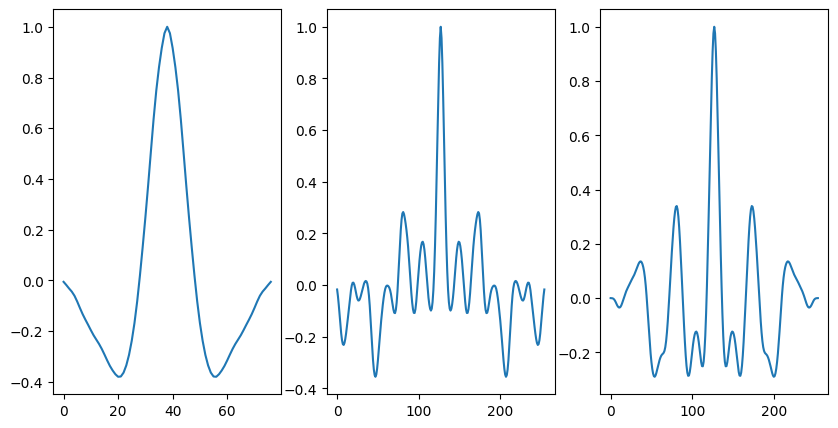

In [12]:
sizes, autocorrs = determine_characteristic_size_jax(
    jnp.asarray(data[0, :, 128:256, :128])
)

fig, axes = plt.subplots(1, len(autocorrs), figsize=(10, 5))
for i, ax in enumerate(axes):
    ax.plot(autocorrs[i])

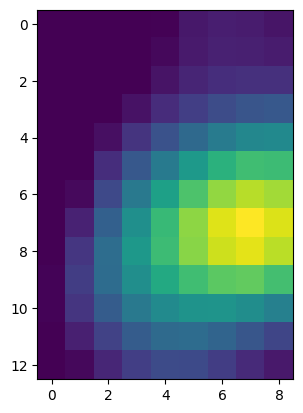

In [13]:
plt.imshow(data[0][: sizes[0], 3 : 3 + sizes[1], 200])

In [ ]:
pearson_r(X[above_threshold], Y[above_threshold])

np.float64(nan)

In [ ]:
above_threshold

array([False, False, False, ..., False, False, False], shape=(638976,))

In [ ]:
pixel_sizes

array([0.14412245, 0.03130297, 0.03130297], dtype=float32)

In [ ]:
mip = np.max(data, axis=1)
mip.shape

(2, 512, 512)

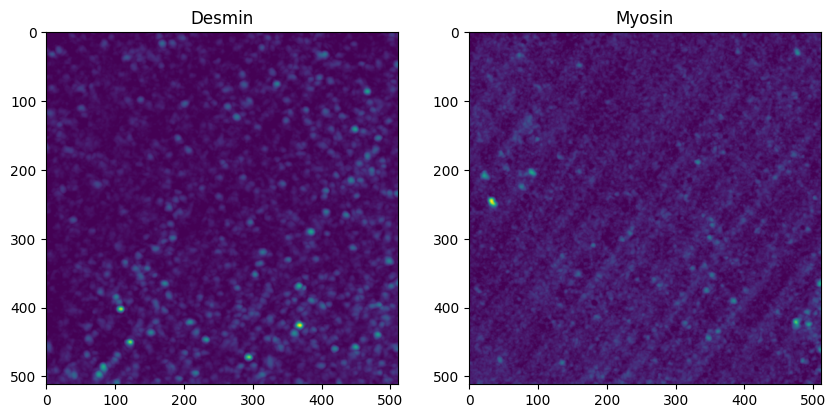

In [ ]:
from matplotlib.colors import ListedColormap


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, (ax, name) in enumerate(zip(axes, ("Desmin", "Myosin"))):
    # ax.imshow(np.mean(actin[i, :, 200:1200, 1000:2000], axis=0))
    # ax.imshow(np.mean(data[i, *roi], axis=0))
    ax.imshow(mip[i], cmap=ListedColormap(["#FF0000"]), alpha=mip[i])
    ax.set_title(name)

In [9]:
np.min(mip[0])

NameError: name 'mip' is not defined

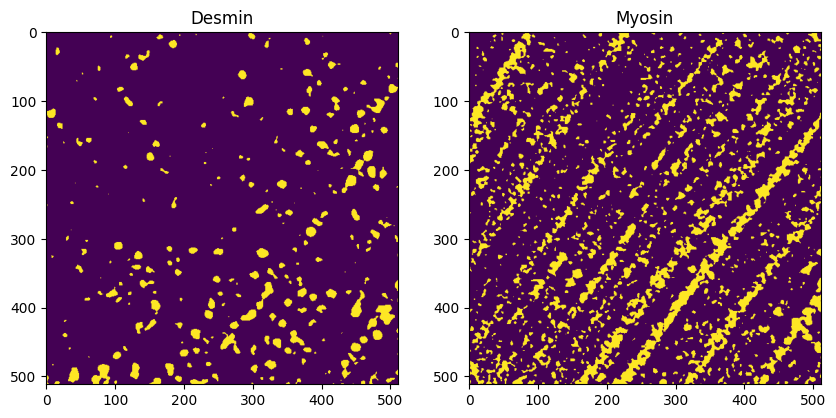

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, (ax, name) in enumerate(zip(axes, ("Desmin", "Myosin"))):
    # ax.imshow(np.mean(actin[i, :, 200:1200, 1000:2000], axis=0))
    img = data[i, 20]
    binarized = img > skimage.filters.threshold_otsu(img)
    ax.imshow(binarized)
    ax.set_title(name)

In [10]:
data[0].shape

(39, 512, 512)

In [19]:
def scramble_image(img, chunk_size, rng):
    # TODO: use einops to make the indexing operations more sensible
    # TODO: add shape informations via jaxtyping
    chunk_grid_shape = tuple(s // width + 1 for s, width in zip(img.shape, chunk_size))
    n_samples = reduce(mul, chunk_grid_shape)
    indices = [
        rng.integers(0, s - width, n_samples) for s, width in zip(img.shape, chunk_size)
    ]
    chunks = np.array(
        [
            img[i : i + chunk_size[0], j : j + chunk_size[1], k : k + chunk_size[2]]
            for i, j, k in zip(*indices)
        ]
    )
    chunks = chunks.reshape((*chunk_grid_shape, *chunk_size))
    img_resampled = rearrange(
        chunks, "grid_x grid_y grid_z x y z -> (grid_x x) (grid_y y) (grid_z z)"
    )
    np.concatenate(np.concatenate(np.concatenate(chunks, axis=-1), axis=-2), axis=-3)
    img_resampled = img_resampled[0 : img.shape[0], 0 : img.shape[1], 0 : img.shape[2]]
    return img_resampled

In [24]:
%%timeit
img_scrambled = scramble_image(img, sizes, np.random.default_rng())

13.5 ms ± 143 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


0.18792072549938643
0.010058753286694264


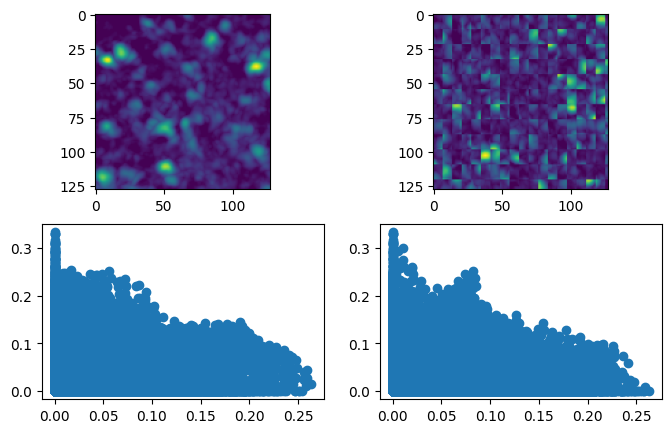

In [53]:
img = data[0, :, 0:128, 0:128]
sizes, autocorrs = determine_characteristic_size(data[0, :, 0:128, 0:128])
img_scrambled = scramble_image(img, sizes, np.random.default_rng())

fig, axes = plt.subplots(2, 2, figsize=(8, 5))
axes[0, 0].imshow(np.max(img, axis=0))
axes[0, 1].imshow(np.max(img_scrambled, axis=0))

axes[1, 0].scatter(
    data[0, :, 0:128, 0:128].flatten(), data[1, :, 0:128, 0:128].flatten()
)
axes[1, 1].scatter(img_scrambled.flatten(), data[1, :, 0:128, 0:128].flatten())
print(pearson_r(data[0, :, 0:128, 0:128].flatten(), data[1, :, 0:128, 0:128].flatten()))
print(pearson_r(img_scrambled.flatten(), data[1, :, 0:128, 0:128].flatten()))

In [54]:
X = img_scrambled.flatten()
Y = data[1, :, 0:128, 0:128].flatten()
a, b = deming_regression(X, Y)
threshold_max = np.minimum(np.max(X), (np.max(Y) - b) / a)
thresholds = np.linspace(0, threshold_max, 100)

threshold = thresholds[-1]

for T in thresholds[::-1]:
    above_threshold = np.logical_and(X > T, Y > a * T + b)
    r = pearson_r(X[~above_threshold], Y[~above_threshold])
    if r <= 0.0:
        break
print(T)
print(r)
print(pearson_r(X[above_threshold], Y[above_threshold]))
M1 = np.sum(X[above_threshold]) / np.sum(X)
M2 = np.sum(Y[above_threshold]) / np.sum(Y)
print(M1, M2)

0.008638461138064208
-8.841002435837024e-05
0.10758854572558171
0.005549045397413558 0.009729470292387092


In [43]:
rng = np.random.default_rng()
num_bootstrap = 200
img_scrambled = [scramble_image(img, sizes, rng) for _ in range(num_bootstrap)]

In [44]:
r_bootstrap = [pearson_r(data[1].flatten(), i.flatten()) for i in img_scrambled]

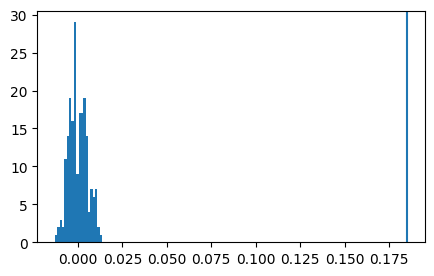

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(r_bootstrap, bins=20)
r_data = pearson_r(data[1].flatten(), data[0].flatten())
ax.axvline(r_data)

In [112]:
rng = np.random.default_rng()
chunk_sample_shape = (
    data[0].shape[-1] // fwhm_x + 1,
    data[0].shape[-2] // fwhm_y + 1,
    data[0].shape[-3] // fwhm_z + 1,
)
N = (
    (data[0].shape[-1] // fwhm_x + 1)
    * (data[0].shape[-2] // fwhm_y + 1)
    * (data[0].shape[-3] // fwhm_z + 1)
)
idx_x = rng.integers(0, data[0].shape[-1] - fwhm_x, N)
idx_y = rng.integers(0, data[0].shape[-2] - fwhm_y, N)
idx_z = rng.integers(0, data[0].shape[-3] - fwhm_z, N)

In [113]:
chunks = np.array(
    [
        data[0][k : k + fwhm_z, j : j + fwhm_y, i : i + fwhm_x]
        for i, j, k in zip(idx_x, idx_y, idx_z)
    ]
)

In [114]:
chunks = chunks.reshape((*chunk_sample_shape, fwhm_z, fwhm_y, fwhm_x))

In [115]:
chunks.shape

(9, 6, 6, 7, 101, 63)

In [116]:
img.shape

(39, 512, 512)

In [117]:
img_resampled = np.concatenate(
    np.concatenate(np.concatenate(chunks, axis=-1), axis=-2), axis=-3
)
img_resampled = img_resampled[0 : img.shape[0], 0 : img.shape[1], 0 : img.shape[2]]

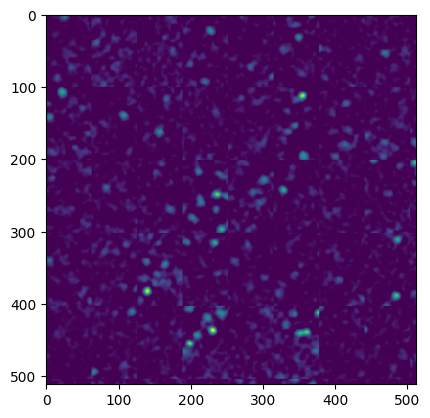

In [118]:
plt.imshow(img_resampled[20])

Text(0.6174999999999999, 0.5850000000000001, '$r=-0.1554$')

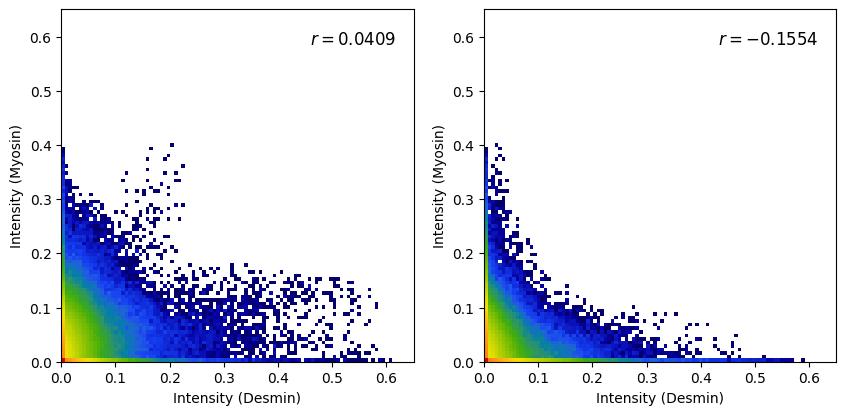

In [119]:
def pearson_correlation_coefficient(channel_1, channel_2):
    threshold_1 = skimage.filters.threshold_otsu(channel_1)
    threshold_2 = skimage.filters.threshold_otsu(channel_2)

    mask = np.logical_and(channel_1 >= threshold_1, channel_2 >= threshold_2)
    return scipy.stats.pearsonr(channel_1[mask], channel_2[mask]), (
        threshold_1,
        threshold_2,
    )


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
range_max = 0.65

corrcoef, thresholds = pearson_correlation_coefficient(*data[:, *roi])
h = axes[0].hist2d(
    data[0, *roi].flatten(),
    data[1, *roi].flatten(),
    bins=100,
    range=[[0, range_max], [0, range_max]],
    norm=mcolors.LogNorm(),
    cmap=cc.cm.rainbow4,
)
axes[0].set_aspect("equal", "box")
fig.colorbar(h[3], ax=ax, label="Number of voxels")

axes[0].set_xlabel("Intensity (Desmin)")
axes[0].set_ylabel("Intensity (Myosin)")
axes[0].text(
    0.95 * range_max,
    0.9 * range_max,
    f"$r={corrcoef.statistic:.4f}$",
    color="black",
    fontsize="large",
    fontweight="bold",
    ha="right",
)

corrcoef, thresholds = pearson_correlation_coefficient(
    img_resampled[*roi], data[1, *roi]
)
h = axes[1].hist2d(
    img_resampled[*roi].flatten(),
    data[1, *roi].flatten(),
    bins=100,
    range=[[0, range_max], [0, range_max]],
    norm=mcolors.LogNorm(),
    cmap=cc.cm.rainbow4,
)
axes[1].set_aspect("equal", "box")
fig.colorbar(h[3], ax=ax, label="Number of voxels")

axes[1].set_xlabel("Intensity (Desmin)")
axes[1].set_ylabel("Intensity (Myosin)")
axes[1].text(
    0.95 * range_max,
    0.9 * range_max,
    f"$r={corrcoef.statistic:.4f}$",
    color="black",
    fontsize="large",
    fontweight="bold",
    ha="right",
)

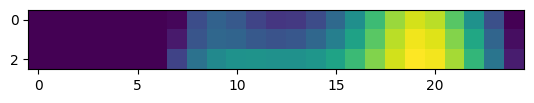

In [74]:
plt.imshow(data[0][:fwhm_z, :fwhm_y, 200])

In [ ]:
autocorr_x = np.mean(out, axis=(1, 2))
autocorr_x = autocorr_x / np.max(autocorr_x)
print(f"FWHM x: {np.sum(autocorr_x - 0.5 >= 0)}")
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(autocorr_x)


np.int64(7)

In [57]:
stuff = np.mean(out, axis=(1, 2))
stuff[0]

np.float64(-0.15762514497912172)

In [60]:
stuff - stuff[::-1]

array([ 1.11022302e-16,  2.77555756e-17,  1.66533454e-16, -2.22044605e-16,
        1.11022302e-16,  5.55111512e-16,  1.72084569e-15, -7.21644966e-16,
        1.22124533e-15, -2.22044605e-16,  2.41473508e-15, -4.16333634e-16,
        2.44249065e-15,  1.26287869e-15,  4.14598911e-16, -1.11022302e-15,
       -5.96744876e-16,  4.99600361e-16, -1.54043445e-15, -5.82867088e-16,
       -1.80411242e-16,  1.32706346e-15,  7.63278329e-16,  1.05471187e-15,
        4.57966998e-16,  2.06779038e-15, -1.30451205e-15,  8.11850587e-16,
        9.80118764e-16, -1.53349555e-15,  2.75474088e-15, -7.91033905e-16,
       -7.35522754e-15,  2.22044605e-16,  2.22044605e-16, -1.66533454e-15,
       -2.22044605e-16,  4.44089210e-15,  0.00000000e+00, -4.44089210e-15,
        2.22044605e-16,  1.66533454e-15, -2.22044605e-16, -2.22044605e-16,
        7.35522754e-15,  7.91033905e-16, -2.75474088e-15,  1.53349555e-15,
       -9.80118764e-16, -8.11850587e-16,  1.30451205e-15, -2.06779038e-15,
       -4.57966998e-16, -

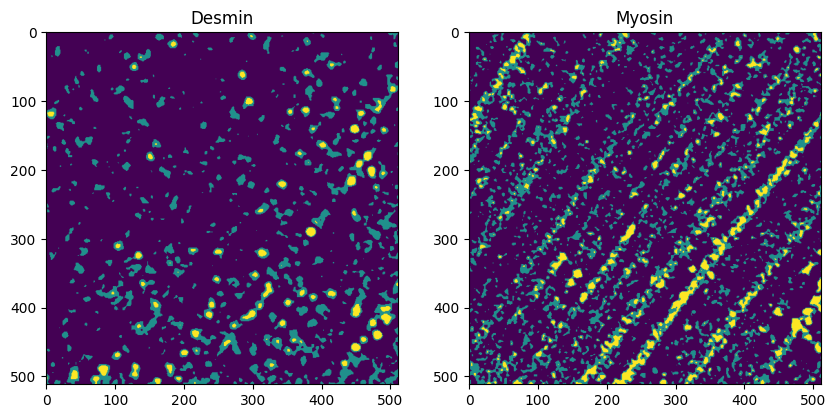

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, (ax, name) in enumerate(zip(axes, ("Desmin", "Myosin"))):
    # ax.imshow(np.mean(actin[i, :, 200:1200, 1000:2000], axis=0))
    img = data[i, 20]
    thresholds = skimage.filters.threshold_multiotsu(img)
    ax.imshow(np.digitize(img, bins=thresholds))
    ax.set_title(name)

(0.0, 0.2)

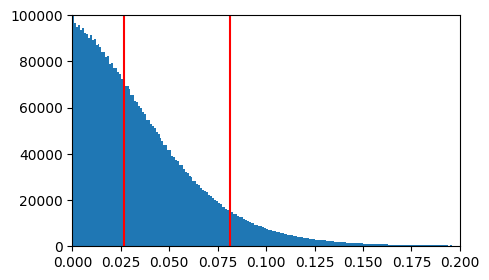

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(data[1].flatten(), bins=1000)
ax.axvline(thresholds[0], color="red")
ax.axvline(thresholds[1], color="red")
ax.set_ylim((0, 100000))
ax.set_xlim((0, 0.2))

In [30]:
def pearson_correlation_coefficient(channel_1, channel_2):
    threshold_1 = skimage.filters.threshold_otsu(channel_1)
    threshold_2 = skimage.filters.threshold_otsu(channel_2)

    mask = np.logical_and(channel_1 >= threshold_1, channel_2 >= threshold_2)
    return scipy.stats.pearsonr(channel_1[mask], channel_2[mask]), (
        threshold_1,
        threshold_2,
    )


corrcoef, thresholds = pearson_correlation_coefficient(*data[:, *roi])

In [31]:
corrcoef.statistic

np.float64(0.04087356408293242)

Text(0.6174999999999999, 0.5850000000000001, '$r=0.0409$')

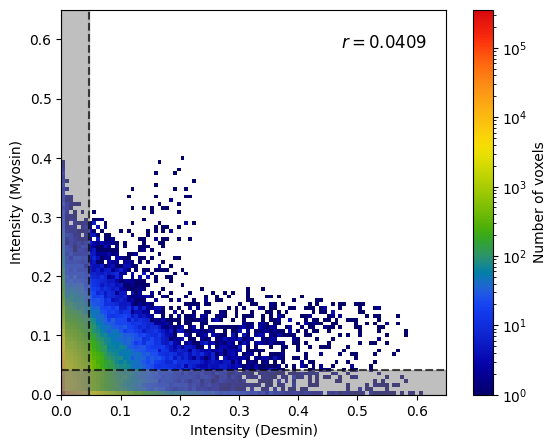

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
range_max = 0.65
h = ax.hist2d(
    data[0, *roi].flatten(),
    data[1, *roi].flatten(),
    bins=100,
    range=[[0, range_max], [0, range_max]],
    norm=mcolors.LogNorm(),
    cmap=cc.cm.rainbow4,
)
ax.set_aspect("equal", "box")
fig.colorbar(h[3], ax=ax, label="Number of voxels")
ax.axvline(x=thresholds[0], ls="--", color="black", alpha=0.7)
ax.axvspan(0.0, thresholds[0], color="gray", alpha=0.5)
ax.axhline(y=thresholds[1], ls="--", color="black", alpha=0.7)
ax.axhspan(0.0, thresholds[1], color="gray", alpha=0.5)
ax.set_xlabel("Intensity (Desmin)")
ax.set_ylabel("Intensity (Myosin)")
ax.text(
    0.95 * range_max,
    0.9 * range_max,
    f"$r={corrcoef.statistic:.4f}$",
    color="black",
    fontsize="large",
    fontweight="bold",
    ha="right",
)

In [12]:
data, pixel_sizes = read_SIM_data(datadir / "actin/Image10_actin_SIM2.h5")
roi = (slice(10, 33), slice(1200, 1600), slice(200, 600))

In [13]:
data.shape

(2, 45, 2048, 2048)

In [14]:
pixel_sizes

array([0.12593877, 0.01565149, 0.01565149], dtype=float32)

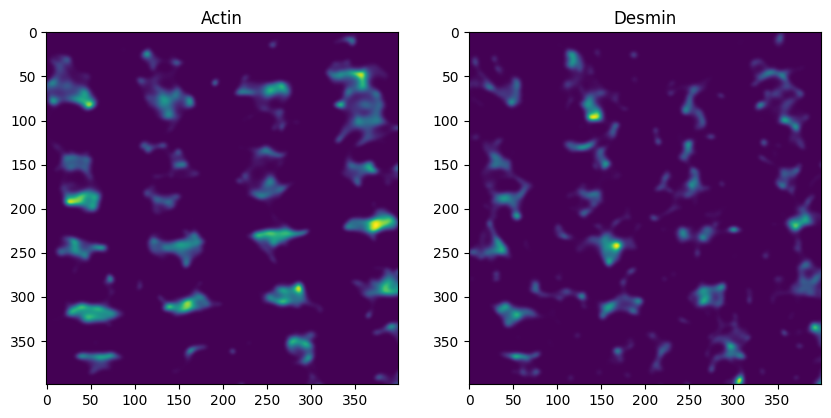

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, (ax, name) in enumerate(zip(axes, ("Actin", "Desmin"))):
    # ax.imshow(np.mean(actin[i, :, 200:1200, 1000:2000], axis=0))
    ax.imshow(np.mean(data[i, *roi], axis=0))
    ax.set_title(name)

In [29]:
grid = pv.ImageData(
    dimensions=np.array(data[0].shape[::-1]) + 1, spacing=pixel_sizes[::-1]
)
grid.cell_data["desmin"] = np.permute_dims(data[1], (2, 1, 0)).flatten(order="F")

grid2 = pv.ImageData(
    dimensions=np.array(data[0].shape[::-1]) + 1, spacing=pixel_sizes[::-1]
)
grid2.cell_data["actin"] = np.permute_dims(data[0], (2, 1, 0)).flatten(order="F")

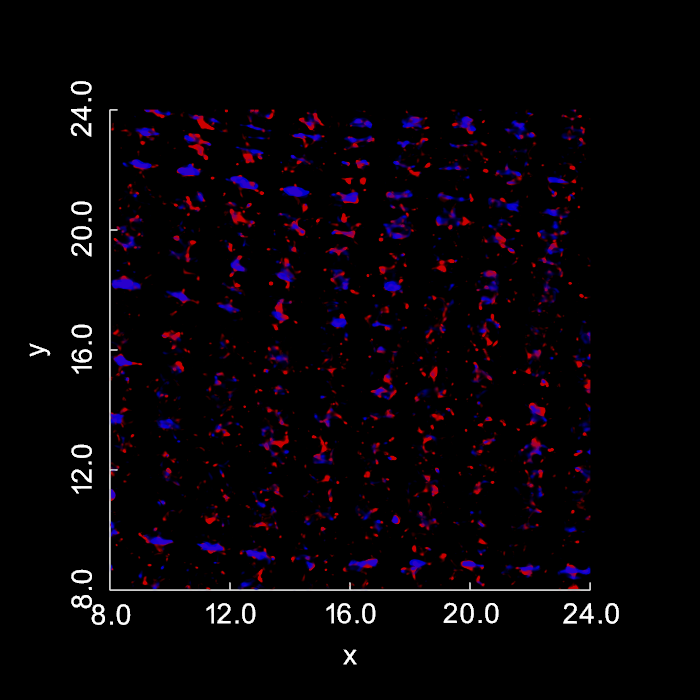

In [30]:
pl = pv.Plotter(notebook=True, window_size=(700, 700))
actor = pl.add_volume(
    grid.extract_subset([512, 1536, 512, 1536, 0, 45]),
    cmap=["#FF0000"],
    opacity=[0.0, 0.1, 0.8],
    clim=(0, 0.2),
    blending="maximum",
    show_scalar_bar=False,
)
actor.prop.interpolation_type = "linear"
actor = pl.add_volume(
    grid2.extract_subset([512, 1536, 512, 1536, 0, 45]),
    cmap=["#0000FF"],
    opacity=[0.0, 0.1, 0.8],
    clim=(0, 0.2),
    # opacity_unit_distance=1.5,
    blending="maximum",
    show_scalar_bar=False,
)
actor.prop.interpolation_type = "linear"
pl.set_background(color="black")
pl.enable_parallel_projection()

pl.view_xy()
axis = pl.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="x",
    ytitle="y",
)
pl.show()

In [37]:
corrcoef, thresholds = pearson_correlation_coefficient(data[1, *roi], data[0, *roi])

Text(0.6174999999999999, 0.5850000000000001, '$r=0.2458$')

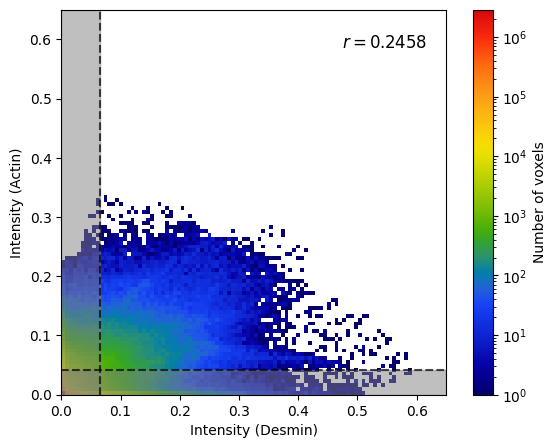

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
range_max = 0.65
h = ax.hist2d(
    data[1, *roi].flatten(),
    data[0, *roi].flatten(),
    bins=100,
    range=[[0, range_max], [0, range_max]],
    norm=mcolors.LogNorm(),
    cmap=cc.cm.rainbow4,
)
ax.set_aspect("equal", "box")
fig.colorbar(h[3], ax=ax, label="Number of voxels")
ax.axvline(x=thresholds[0], ls="--", color="black", alpha=0.7)
ax.axvspan(0.0, thresholds[0], color="gray", alpha=0.5)
ax.axhline(y=thresholds[1], ls="--", color="black", alpha=0.7)
ax.axhspan(0.0, thresholds[1], color="gray", alpha=0.5)
ax.set_xlabel("Intensity (Desmin)")
ax.set_ylabel("Intensity (Actin)")
ax.text(
    0.95 * range_max,
    0.9 * range_max,
    f"$r={corrcoef.statistic:.4f}$",
    color="black",
    fontsize="large",
    fontweight="bold",
    ha="right",
)

In [31]:
data, pixel_sizes = read_SIM_data(datadir / "alpha-actinin/Image2_SIM2.h5")
roi = (slice(10, 33), slice(200, 600), slice(1000, 1400))

In [34]:
data.shape

(2, 45, 2048, 2048)

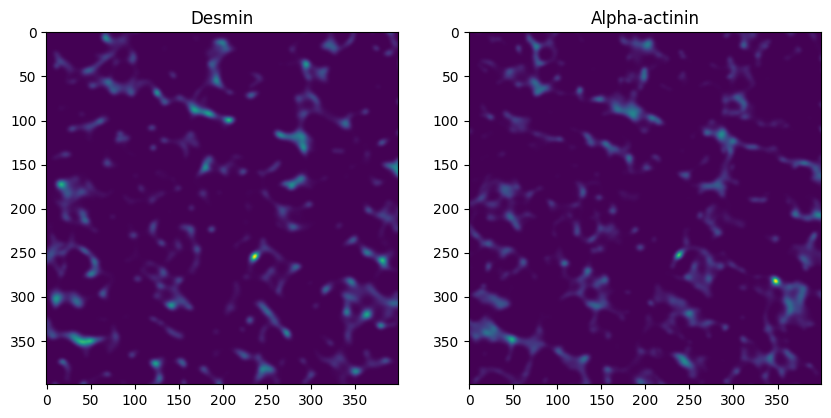

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, (ax, name) in enumerate(zip(axes, ("Desmin", "Alpha-actinin"))):
    # ax.imshow(np.mean(actin[i, :, 200:1200, 1000:2000], axis=0))
    ax.imshow(np.mean(data[i, *roi], axis=0))
    ax.set_title(name)

In [33]:
grid = pv.ImageData(
    dimensions=np.array(data[0].shape[::-1]) + 1, spacing=pixel_sizes[::-1]
)
grid.cell_data["desmin"] = np.permute_dims(data[0], (2, 1, 0)).flatten(order="F")

grid2 = pv.ImageData(
    dimensions=np.array(data[0].shape[::-1]) + 1, spacing=pixel_sizes[::-1]
)
grid2.cell_data["alpha-actinin"] = np.permute_dims(data[1], (2, 1, 0)).flatten(
    order="F"
)


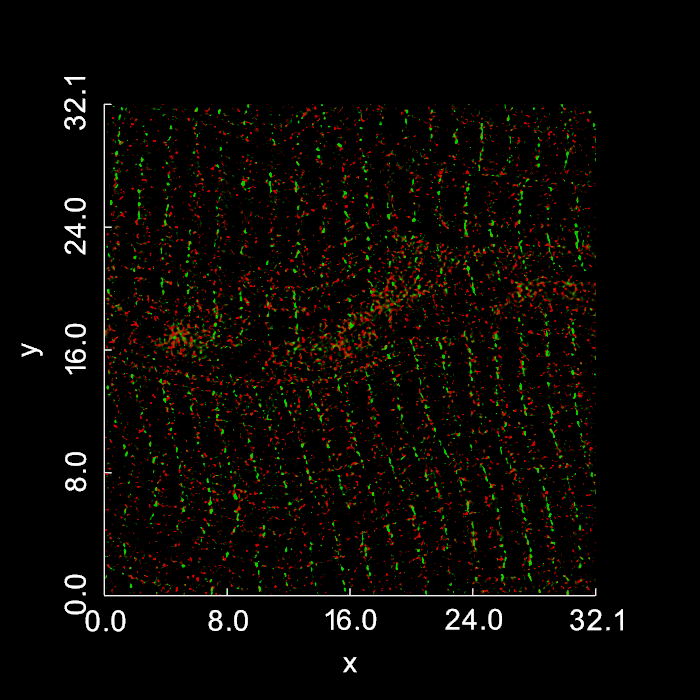

In [19]:
pl = pv.Plotter(notebook=True, window_size=(700, 700))
actor = pl.add_volume(
    grid,
    cmap=["#FF0000"],
    opacity=[0.0, 0.1, 0.8],
    clim=(0, 0.2),
    blending="maximum",
    show_scalar_bar=False,
)
actor.prop.interpolation_type = "linear"
actor = pl.add_volume(
    grid2,
    cmap=["#00FF00"],
    opacity=[0.0, 0.1, 0.8],
    clim=(0, 0.2),
    # opacity_unit_distance=1.5,
    blending="maximum",
    show_scalar_bar=False,
)
actor.prop.interpolation_type = "linear"
pl.set_background(color="black")
pl.enable_parallel_projection()

pl.view_xy()
axis = pl.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="x",
    ytitle="y",
)
pl.show()

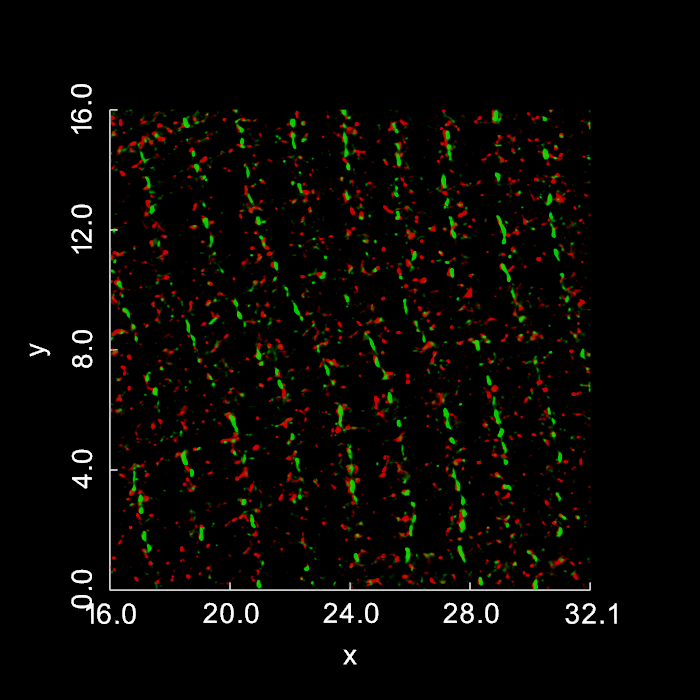

In [35]:
pl = pv.Plotter(notebook=True, window_size=(700, 700))
actor = pl.add_volume(
    grid.extract_subset([1024, 2048, 0, 1024, 0, 45]),
    cmap=["#FF0000"],
    opacity=[0.0, 0.1, 0.8],
    clim=(0, 0.2),
    blending="maximum",
    show_scalar_bar=False,
)
actor.prop.interpolation_type = "linear"
actor = pl.add_volume(
    grid2.extract_subset([1024, 2048, 0, 1024, 0, 45]),
    cmap=["#00FF00"],
    opacity=[0.0, 0.1, 0.8],
    clim=(0, 0.2),
    # opacity_unit_distance=1.5,
    blending="maximum",
    show_scalar_bar=False,
)
actor.prop.interpolation_type = "linear"
pl.set_background(color="black")
pl.enable_parallel_projection()

pl.view_xy()
axis = pl.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="x",
    ytitle="y",
)
pl.show()

In [41]:
corrcoef, thresholds = pearson_correlation_coefficient(*data[:, *roi])

Text(0.6174999999999999, 0.5850000000000001, '$r=0.1666$')

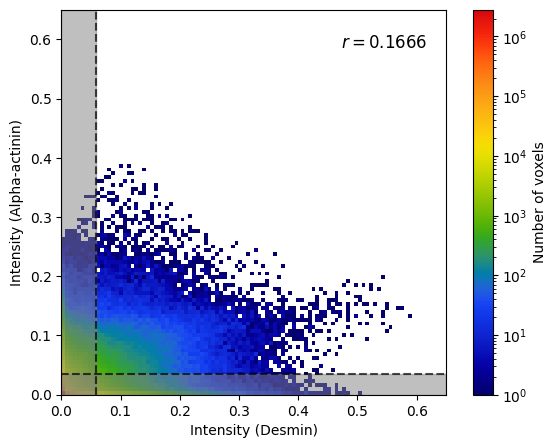

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
range_max = 0.65
h = ax.hist2d(
    data[0, *roi].flatten(),
    data[1, *roi].flatten(),
    bins=100,
    range=[[0, range_max], [0, range_max]],
    norm=mcolors.LogNorm(),
    cmap=cc.cm.rainbow4,
)
ax.set_aspect("equal", "box")
fig.colorbar(h[3], ax=ax, label="Number of voxels")
ax.axvline(x=thresholds[0], ls="--", color="black", alpha=0.7)
ax.axvspan(0.0, thresholds[0], color="gray", alpha=0.5)
ax.axhline(y=thresholds[1], ls="--", color="black", alpha=0.7)
ax.axhspan(0.0, thresholds[1], color="gray", alpha=0.5)
ax.set_xlabel("Intensity (Desmin)")
ax.set_ylabel("Intensity (Alpha-actinin)")
ax.text(
    0.95 * range_max,
    0.9 * range_max,
    f"$r={corrcoef.statistic:.4f}$",
    color="black",
    fontsize="large",
    fontweight="bold",
    ha="right",
)